# Continious Generative Models
---

Цели:
1. Познакомиться с непрерывними нормализующими потоками
2. Познакомиться с непрерывными диффузионными моделями

Содержание:
- [Continious Normalizing Flow](#cnf)
    - [Теорема о замене переменной](#theor)
    - [Многомерные потоки](#mult)
    - [Использование динамики во времени](#timedep)
- [Continious Diffusion Models](#cdm)
    - [Прямой процесс диффузии](#forward)
    - [Обратный процесс диффузии](#reverse)
    - [Score-Based Generative Modeling Throught SDE](#sdm)

Ссылки:
1. [Neural Ordinary Differential Equations](https://arxiv.org/pdf/1806.07366.pdf)
2. [Знакомство с Neural ODE](https://habr.com/ru/companies/ods/articles/442002/)
3. [PointFlow: 3D Point Cloud Generation with Continuous Normalizing Flows](https://arxiv.org/pdf/1906.12320v3.pdf)
4. [Multi-Resolution Continuous Normalizing Flows](https://arxiv.org/pdf/2106.08462v5.pdf)
5. [Efficient and Accurate Gradients for Neural SDEs](https://arxiv.org/pdf/2105.13493.pdf)
6. [Score-Based Generative Modeling through Stochastic Differential Equations](https://arxiv.org/pdf/2011.13456.pdf)

Используемые пакеты:
1. [Репо torchdiffeq](https://github.com/rtqichen/torchdiffeq/)
2. [Репо torchsde](https://github.com/google-research/torchsde/)

<a name="cnf"></a>
## Continious Normalizing Flow

Давайте еще раз вспомним про постановку задачи для нормализующих потоков

<figure>
<img src="https://lilianweng.github.io/posts/2018-10-13-flow-models/normalizing-flow.png" alt="Примеры схем генеративных моделй" style="width:100%">
<figcaption align = "center">Иллюстрация преобразования нормально распределенного z0 в zK из реального  распределения.</figcaption>
</figure>

Это модель с дискретным временем, шаг которой можно описать как
$$
z_1 = f(z_0) \Longrightarrow \log p(z_1) = \log p(z_0) - \log\left|\det\dfrac{df}{dz_0}\right|
$$
В частности при использовании планарных потоков шаг можно переписать
$$
z(t+1) = z(t) + uh(w^T z(t) + b) \Longrightarrow \log p(z(t+1)) = \log p(z(t)) - \log\left|1 + u^T\dfrac{dh}{dz}\right|
$$
Теперь будем увеличивать число шагов и уменьшать размер шага до тех пор пока задача не станет непрерывной. Тогда выражения выше можно переписать через малые приращения
$$
z(t+\Delta t) = z(t) + uh(w^T z(t) + b) \Longrightarrow \log p(z(t+\Delta t)) = \log p(z(t)) - \log\left|1 + u^T\dfrac{dh}{dz}\right|
$$
$$
z(t+\Delta t) - z(t) = uh(w^T z(t) + b) \Longrightarrow \log p(z(t+\Delta t)) - \log p(z(t)) = - \log\left|1 + u^T\dfrac{dh}{dz}\right|
$$
При взятии предела $\Delta t\to 0$ разность можно переписать выражения через производные
$$
\dfrac{dz(t)}{dt} = uh(w^T z(t) + b) \Longrightarrow \dfrac{\partial\log{p(z(t))}}{\partial t} = -u^T\dfrac{dh}{dz}
$$

<a name="theor"></a>
### Теорема о замене переменной

Положим, что $z(t)$ — непрерывная случайная величина с плотностью $p(z(t))$, зависящая от времени. Положим, что $dz(t)/dt = f(z(t), t)$ — дифференциальное уравнение, описывающее изменение нашей величины от времени. Положим, что $f$ — Липшицево отображение, тогда
$$
\dfrac{∂\log p(z(t))}{∂t} = -\text{tr}\left(\dfrac{df}{dz(t)}\right)
$$

Тогда в общем виде непрерывные потоки имеют вид
$$
\dfrac{dz(t)}{dt} = f(z(t), t, \theta),~\dfrac{∂\log p(z(t))}{∂t} = -\text{tr}\left(\dfrac{df}{dz(t)}\right)
$$

<a name="mult"></a>
### Многомерные потоки

Для нелинейных потоков $f$, след Якобиана обладает следующим свойством:
$$
\text{tr}\left(\sum\limits_n J_n\right) = \sum\limits_n \text{tr}\left(J_n\right)
$$
Таким образом если наша динамика порождена суммой функций, дифференциальное уравнение логарифма плотности также является суммой
$$
\dfrac{dz(t)}{dt} = \sum\limits_{i=1}^Mf_i(z(t)) \Longrightarrow \dfrac{∂\log p(z(t))}{∂t} = \sum\limits_{i=1}^M\text{tr}\left
(\dfrac{df_i}{dz}\right)
$$

Получается мы можем дешево (по сложности) обучать потоковые модели с большим числом скрытых слоев со сложностью равной числу скрытых слоев $O(M)$. В тоже время использование таких "широких" потоков в обычных нормализационных моделях имеет сложность $O(M^3)$.

<a name="timedep"></a>
### Использование динамики во времени

Также интересно то, что мы можем использовать один поток с параметром времени, то есть явно зависимый от времени $f(z(t), t)$, а не $f(z(t))$. Также авторы метода предлагают новый стробирующий метод
$$
\dfrac{dz(t)}{dt} = \sum\limits_nσ_n(t)f_n(z),~σ\in(0,1)
$$
где $σ_n(t)$ — нейронная сеть.

In [1]:
!pip install diffusers torchsde torchdiffeq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 9.3 MB/s eta 0:00:00


In [2]:
import math
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
from tqdm.notebook import tqdm
from pathlib import Path
from sklearn.datasets import make_moons

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, ToPILImage, Lambda, Resize, Compose, Normalize
from torchvision.utils import make_grid, save_image

from diffusers import UNet2DModel
from torchsde import sdeint
from torchdiffeq import odeint_adjoint as odeint

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def get_batch(num_samples):
    points, _ = make_moons(n_samples=num_samples, noise=0.06)
    points = (points - points.mean(0)) / points.std(0) * 1.5
    x = torch.tensor(points).type(torch.float32).to(device)
    logp_diff_t1 = torch.zeros(num_samples, 1).type(torch.float32).to(device)

    return(x, logp_diff_t1)

In [ ]:
def plot_flow(
    p_z0,
    func,
    num_samples: int = 30_000,
    num_timestemps: int = 20,
    name: str = 'cnf_ode',
    t0: float = 0.,
    t1: float = 1.
):
    Path('imgs').mkdir(exist_ok=True)

    timesteps = torch.linspace(t0, t1, num_timestemps, device=device)
    target_sample, _ = get_batch(num_samples)

    z_t0 = p_z0.sample([num_samples]).to(device)
    logp_diff_t0 = torch.zeros(num_samples, 1).type(torch.float32).to(device)

    z_t_samples, _ = odeint(
        func,
        (z_t0, logp_diff_t0),
        timesteps,
        atol=1e-5,
        rtol=1e-5,
        method='dopri5',
    )

    x = np.linspace(-3, 3, 100)
    y = np.linspace(-3, 3, 100)
    points = np.vstack(np.meshgrid(x, y)).reshape([2, -1]).T

    z_t1 = torch.tensor(points).type(torch.float32).to(device)
    logp_diff_t1 = torch.zeros(z_t1.shape[0], 1).type(torch.float32).to(device)

    z_t_density, logp_diff_t = odeint(
        func,
        (z_t1, logp_diff_t1),
        timesteps.flip(0),
        atol=1e-5,
        rtol=1e-5,
        method='dopri5',
    )

    for (t, z_sample, z_density, logp_diff) in zip(timesteps, z_t_samples, z_t_density, logp_diff_t):

        logp = p_z0.log_prob(z_density) - logp_diff.view(-1)

        fig = plt.figure(figsize=(10, 3))
        plt.axis('off')
        plt.margins(0, 0)
        plt.suptitle(f'{t:.2f}s', size=15)
        plt.tight_layout()

        ax1 = fig.add_subplot(1, 3, 1)
        ax1.set_title('Target')
        ax1.get_xaxis().set_ticks([])
        ax1.get_yaxis().set_ticks([])

        ax2 = fig.add_subplot(1, 3, 2)
        ax2.set_title('Samples')
        ax2.get_xaxis().set_ticks([])
        ax2.get_yaxis().set_ticks([])

        ax3 = fig.add_subplot(1, 3, 3)
        ax3.set_title('Probability')
        ax3.get_xaxis().set_ticks([])
        ax3.get_yaxis().set_ticks([])

        ax1.hist2d(*target_sample.detach().cpu().T.numpy(), bins=300, density=True, range=[[-3, 3], [-3, 3]])
        ax2.hist2d(*z_sample.detach().cpu().T.numpy(), bins=300, density=True, range=[[-3, 3], [-3, 3]])
        plt.pcolormesh(*z_t1.T.view(2, 100, 100).detach().cpu(), logp.exp().view(100, 100).detach().cpu())
        plt.savefig('imgs/cnf-%.2f.png' % t)
        plt.close()

    images = []
    filenames = sorted(list(Path('imgs/').glob('*.png')))
    for filename in filenames:
        images.append(imageio.imread(str(filename)))
    imageio.mimsave(f'{name}.gif', images, duration=5, format='GIF')
    shutil.rmtree('imgs')


In [ ]:
def trace_df_dz(f, z):
    """Calculates the trace of the Jacobian df/dz.
    Stolen from: https://github.com/rtqichen/ffjord/blob/master/lib/layers/odefunc.py#L13
    """
    sum_diag = 0.
    for i in range(z.shape[1]):
        sum_diag += torch.autograd.grad(f[:, i].sum(), z, create_graph=True)[0].contiguous()[:, i].contiguous()

    return sum_diag.contiguous()


In [ ]:
class PlanarFlow(nn.Module):

    def __init__(self, inp: int, width: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(inp, width),
            nn.Tanh(),
            nn.Linear(width, width),
            nn.Tanh(),
            nn.Linear(width, inp, bias=False)
        )

    def forward(self, z):
        return self.net(z)

class CNF(nn.Module):

    def __init__(self, inp: int, width: int):
        super().__init__()
        self.net = PlanarFlow(inp, width)

    def forward(self, t, state):
        z = state[0]
        logp_z = state[1]
        with torch.set_grad_enabled(True):
            z.requires_grad_(True)
            dz_dt = self.net(z)
            dlogp_z_dt = -trace_df_dz(dz_dt, z).view(z.size(0), 1)
        return (dz_dt, dlogp_z_dt)

In [ ]:
random.seed(0);
np.random.seed(0);
torch.manual_seed(0);
torch.cuda.manual_seed(0);
torch.cuda.manual_seed_all(0);

epoches = 1000
t0, t1 = 0, 1
func = CNF(2, 256).to(device)
optimizer = torch.optim.Adam(func.parameters(), lr=1e-3)
p_z0 = torch.distributions.MultivariateNormal(
        loc=torch.tensor([0.0, 0.0]).to(device),
        covariance_matrix=torch.tensor([[1., 0.0], [0.0, 1.]]).to(device)
    )
pbar = tqdm(total=epoches)
total_loss = []
with pbar:
    for i in range(epoches):
        optimizer.zero_grad()
        x, logp_diff_t1 = get_batch(512)
        z_t, logp_diff_t = odeint(
            func,
            (x, logp_diff_t1),
            torch.linspace(t1, t0, 10).type(torch.float32).to(device),
            atol=1e-5,
            rtol=1e-5,
            method='midpoint',
            adjoint_method='midpoint'
        )
        z_t0, logp_diff_t0 = z_t[-1], logp_diff_t[-1]
        logp_x = p_z0.log_prob(z_t0).to(device) - logp_diff_t0.view(-1)
        loss = -logp_x.mean(0)
        loss.backward()
        optimizer.step()

        pbar.update(1)
        pbar.set_description("Epoch: %i, Loss: %.3f" % (i, loss.item()))
        total_loss.append(loss.item())


  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
plot_flow(p_z0, func, num_timestemps=60, name='simple_cnf_ode')

![alt](https://github.com/sswt/dive2gai/blob/main/.github/images/w12/simple_cnf_ode.gif?raw=true)

In [ ]:
class CNF(nn.Module):
    """Adapted from the NumPy implementation at:
    https://gist.github.com/rtqichen/91924063aa4cc95e7ef30b3a5491cc52
    Source: https://github.com/rtqichen/torchdiffeq/blob/master/examples/cnf.py
    """
    def __init__(self, in_out_dim, hidden_dim, width):
        super().__init__()
        self.in_out_dim = in_out_dim
        self.hidden_dim = hidden_dim
        self.width = width
        self.hyper_net = HyperNetwork(in_out_dim, hidden_dim, width)

    def forward(self, t, states):
        z = states[0]
        logp_z = states[1]

        batchsize = z.shape[0]

        with torch.set_grad_enabled(True):
            z.requires_grad_(True)

            W, B, U = self.hyper_net(t)

            Z = torch.unsqueeze(z, 0).repeat(self.width, 1, 1)

            h = torch.tanh(torch.matmul(Z, W) + B)
            dz_dt = torch.matmul(h, U).mean(0)

            dlogp_z_dt = -trace_df_dz(dz_dt, z).view(batchsize, 1)

        return (dz_dt, dlogp_z_dt)


def trace_df_dz(f, z):
    """Calculates the trace of the Jacobian df/dz.
    Stolen from: https://github.com/rtqichen/ffjord/blob/master/lib/layers/odefunc.py#L13
    Source: https://github.com/rtqichen/torchdiffeq/blob/master/examples/cnf.py
    """
    sum_diag = 0.
    for i in range(z.shape[1]):
        sum_diag += torch.autograd.grad(f[:, i].sum(), z, create_graph=True)[0].contiguous()[:, i].contiguous()

    return sum_diag.contiguous()


class HyperNetwork(nn.Module):
    """Hyper-network allowing f(z(t), t) to change with time.

    Adapted from the NumPy implementation at:
    https://gist.github.com/rtqichen/91924063aa4cc95e7ef30b3a5491cc52
    Source: https://github.com/rtqichen/torchdiffeq/blob/master/examples/cnf.py
    HyperNetwork: https://arxiv.org/pdf/1609.09106.pdf
    """
    def __init__(self, in_out_dim, hidden_dim, width):
        super().__init__()

        blocksize = width * in_out_dim

        self.fc1 = nn.Linear(1, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 3 * blocksize + width)

        self.in_out_dim = in_out_dim
        self.hidden_dim = hidden_dim
        self.width = width
        self.blocksize = blocksize

    def forward(self, t):
        # predict params
        params = t.reshape(1, 1)
        params = torch.tanh(self.fc1(params))
        params = torch.tanh(self.fc2(params))
        params = self.fc3(params)

        # restructure
        params = params.reshape(-1)
        W = params[:self.blocksize].reshape(self.width, self.in_out_dim, 1)

        U = params[self.blocksize:2 * self.blocksize].reshape(self.width, 1, self.in_out_dim)

        G = params[2 * self.blocksize:3 * self.blocksize].reshape(self.width, 1, self.in_out_dim)
        U = U * torch.sigmoid(G)

        B = params[3 * self.blocksize:].reshape(self.width, 1, 1)
        return [W, B, U]


In [ ]:
random.seed(0);
np.random.seed(0);
torch.manual_seed(0);
torch.cuda.manual_seed(0);
torch.cuda.manual_seed_all(0);

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

epoches = 1000
t0, t1 = 0, 1
func = CNF(2, 32, 64).to(device)
optimizer = torch.optim.Adam(func.parameters(), lr=1e-3)
p_z0 = torch.distributions.MultivariateNormal(
        loc=torch.tensor([0.0, 0.0]).to(device),
        covariance_matrix=torch.tensor([[1., 0.0], [0.0, 1.]]).to(device)
    )
pbar = tqdm(total=epoches)
total_loss = []
with pbar:
    for i in range(epoches):
        optimizer.zero_grad()
        x, logp_diff_t1 = get_batch(512)
        z_t, logp_diff_t = odeint(
            func,
            (x, logp_diff_t1),
            torch.tensor([t1, t0]).type(torch.float32).to(device),
            atol=1e-5,
            rtol=1e-5,
            method='dopri5',
            adjoint_method='dopri5'
        )
        z_t0, logp_diff_t0 = z_t[-1], logp_diff_t[-1]
        logp_x = p_z0.log_prob(z_t0).to(device) - logp_diff_t0.view(-1)
        loss = -logp_x.mean(0)
        loss.backward()
        optimizer.step()

        pbar.update(1)
        pbar.set_description("Epoch: %i, Loss: %.3f" % (i, loss.item()))
        total_loss.append(loss.item())


  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
plot_flow(p_z0, func, num_timestemps=60)


![alt](https://github.com/sswt/dive2gai/blob/main/.github/images/w12/cnf_ode.gif?raw=true)

<a name="cdm"></a>
## Continious Diffusion Models

Вспомним еще раз как выглядит классическая модель DDPM
<figure>
<img src="https://raw.githubusercontent.com/sswt/dive2gai/c880aa21c1f781243db9d59b3f72664019f50e8d/unit6/data/ddpm_plot.png" alt="Схема диффузии" style="width:100%">
<figcaption align = "center">Иллюстрация работы DDPM модели.</figcaption>
</figure>
Имеется прямой и обратный процесс. Прямой процесс зашумляет объект, а обратный — восстанавливает его в исходное состояние. Посмотрим как это может выглядить с непрерывным временем.



<a name="forward"></a>
### Прямой процесс диффузии

В дискретных моделях прямой процесс (зашумление) имеет вид
$$
x_i = \sqrt{1-\beta_i}x_{i-1} + \sqrt{\beta_i}z_{i-1}
$$
где $i=1,2,\dots,N$. При $N\to\infty$ получим, что
$$
dx = -\dfrac{1}{2}\beta(t)xdt + \sqrt{\beta(t)}dw
$$
что имеет вид СДУ с дрифтом $f(x(t), t) = -\frac{1}{2}\beta(t)x$ и диффузией $g(t) = \sqrt{\beta(t)}$.


<a name="reverse"></a>
### Обратный процесс диффузии

Обратный процесс непрерывной диффузии имеет вид
$$
dx = [f(x, t) - g(t)^2 \nabla_x\log{p_t(x)}]dt +g(t)d\bar w
$$
где $d\bar w$ — Винерский обратный процесс (от $T$ до $0$), а $dt$ — отрицательное прирощение по времени.

Так как функции $f(x, t)$ и $g(t)$ мы знаем, то можно нейронной сетью аппроксимировать неизвестный член $\nabla_x\log{p_t(x)}\approx s_{\theta}(x(t), t)$ с которым обратный процесс диффузии становится
$$
dx = [f(x, t) - g(t)^2 s_{\theta}(x(t), t)]dt +g(t)d\bar w
$$

Казалось бы, что все необходимое есть на руках. Сначала решаем прямое СДУ, а потом от результата считаем обратное СДУ и считаем лосс для обучения модели. Однако такой подход будет очень сложный в вычислительном плане и имеет смысл его упростить.

<a name="sgm"></a>
### Score-Based Generative Modeling Throught SDE

Так как в нашем процессе неизвестным является только величина $\nabla_x\log{p_t(x)}$ называемая функцией оценки (score function) давайте обучать модель оценивать этот скор. Тогда наша задача оптимизации имеет следующий вид
$$
\theta^* = \operatorname*{argmin}_\theta\mathbb{E}_t\{\lambda(t)\mathbb{E}_{x(0)}\mathbb{E}_{x(T)|x(0)}[||s_\theta(x, t)-\nabla_{x(t)}\log{p_{t}(x)}||_2^2]\}
$$
здесь $p_{t}(x)$ — распределение $x(t)$.

Однако так как $p_{t}(x)$ мы не знаем и рассчитать аналитически не можем предлагается его заменить на ядро перехода из момента $0$ в произвольный момент $t$, $p_{0t}(x(t)|x(0))$. Тогда
$$
\theta^* = \operatorname*{argmin}_\theta\mathbb{E}_t\{\lambda(t)\mathbb{E}_{x(0)}\mathbb{E}_{x(T)|x(0)}[||s_\theta(x, t)-\nabla_{x(t)}\log{p_{0t}(x(t)|x(0))}||_2^2]\}
$$
где $\lambda(t): [0, T]\to\mathbb{R}^+$, выбираем его пропорционально $\lambda(t) \propto 1/\mathbb{E}[||\nabla_{x(t)}\log{p_{0t}(x(t)|x(0))}||_2^2]$, а ядро перехода имеет следующий вид (в зависимости от модели)
$$
p_{0t}(x(t)|x(0)) =
\begin{cases}
\mathcal{N}(x(t); x(0), [\sigma^2(t)-\sigma^2(0)]I) & \text{VE SDE}\\
\mathcal{N}(x(t); x(0)e^{-\frac{1}{2}\int_0^t\beta(s)ds}, I - Ie^{-\int_0^t\beta(s)ds}) & \text{VP SDE}\\
\mathcal{N}(x(t); x(0)e^{-\frac{1}{2}\int_0^t\beta(s)ds}, [1 - e^{-\int_0^t\beta(s)ds}]^2I) & \text{sub-VP SDE}
\end{cases}
$$

А интеграл по $\beta(t)$ легко считается аналитически. В статье используется лиенйная функция $\beta(t)$ так как некоторые свойства модели возможны только для афинных преобразований. Если $\beta(t)$ — линейная функция $\beta(t) = \beta(0) + t\cdot(\beta(T) - \beta(0))$. Тогда интеграл
$$
\int\limits_0^t \beta(s)ds = \int\limits_0^t [\beta(0) + s\cdot(\beta(T) - \beta(0))]ds = \beta(0)\cdot t + (\beta(T) - \beta(0))\cdot\dfrac{t^2}{2}
$$


In [33]:
alpha=0.95

def dequantize(x, nvals=256):
        """[0, 1] -> [0, nvals] -> add uniform noise -> [0, 1]
        Source: https://github.com/google-research/torchsde/blob/master/examples/cont_ddpm.py
        """
        noise = x.new().resize_as_(x).uniform_()
        x = x * (nvals - 1) + noise
        x = x / nvals
        return x

def postprocess(x, alpha=0.95, clamp=True):
    """Source: https://github.com/google-research/torchsde/blob/master/examples/cont_ddpm.py"""
    x = (x.sigmoid() - alpha) / (1 - 2 * alpha)
    return x.clamp(min=0., max=1.) if clamp else x

transform = Compose([
    ToTensor(),
    dequantize,
    Lambda(lambda x: alpha + (1 - 2 * alpha) * x),
    Lambda(lambda x: (x / (1 - x)).log()),
])

mnist = MNIST('../data/', download=True, transform=transform)
# train, _ = torch.utils.data.random_split(mnist, [10000, 50000])
train = DataLoader(mnist, batch_size=256, shuffle=True, drop_last=True)


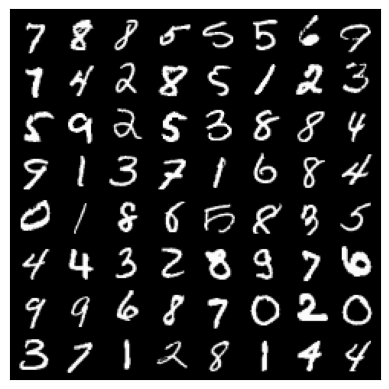

In [34]:
sample = next(iter(train))[0].to(device)
plt.imshow(ToPILImage()(make_grid(postprocess(sample[:64]))))
plt.xticks([])
plt.yticks([])
plt.show()


In [21]:
class ScoreMatching(nn.Module):
    """
    Source: https://github.com/google-research/torchsde/blob/master/examples/cont_ddpm.py
    """

    noise_type = "diagonal"
    sde_type = "stratonovich" # "ito"

    def __init__(
        self,
        model,
        input_size=(1,28,28),
        beta_min=0.1,
        beta_max=20,
        device='cpu'
    ):
        super().__init__()

        self.model = model
        self.input_size = input_size
        self.beta_min = beta_min
        self.beta_max = beta_max
        self.device = device
        self.t0 = 0.
        self.t1 = 1.

    def _beta(self, t):
        """linear beta(t)"""
        return self.beta_min + t * (self.beta_max - self.beta_min)

    def _int_beta(self, t):
        """integrate betas in-time"""
        return self.beta_min * t + 0.5 * t ** 2 * (self.beta_max - self.beta_min)

    def analytical_drift(self, t, y):
        """Drift of SDE"""
        return -0.5 * self._beta(t) * y

    def analytical_diffusion(self, t, y):
        """Diffusion of SDE"""
        return self._beta(t).sqrt().repeat(y.size())

    def analytical_mean(self, t, y0):
        """sub-VP SDE mean of p0t(y(t)|y(0))"""
        return y0 * (- 0.5 * self._int_beta(t)).exp()

    def analytical_var(self, t, y):
        """sub-VP SDE varience of p0t(y(t)|y(0))"""
        return (1 - 1 / self._int_beta(t).exp()).square()

    @torch.no_grad()
    def analytical_score(self, y1, t, y0):
        """nabla_xt p0t(y(t)|y(0))"""
        mean = self.analytical_mean(t, y0)
        var = self.analytical_var(t, y0)
        return - (y1 - mean) / var.clamp_min(1e-5)

    @torch.no_grad()
    def noise_sample(self, t, y):
        """sample noised data with p0t(x(t)|x(0))"""
        mean = self.analytical_mean(t, y)
        var = self.analytical_var(t, y)
        noise = torch.randn_like(mean)
        return mean + noise * var.sqrt()

    def model_score(self, t, y):
        """s(y, t) approximation of score"""
        if t.dim() == 0:
            t = t.repeat(y.shape[0])
        return self.model(t, y)

    def model_drift(self, t, y):
        """Reverse SDE drift"""
        score = self.model_score(-t, y.view((-1, *self.input_size))).flatten(1)
        return -(self.analytical_drift(-t, y) - self.analytical_diffusion(-t, y) ** 2 * score)

    def model_diffusion(self, t, y):
        """Reverse SDE diffusion"""
        return -self.analytical_diffusion(-t, y)

    def forward(self, t, y):
        """Reverse ODE-like SDE"""
        score = self.model_score(-t, y.view((-1, *self.input_size))).flatten(1)
        return -(self.analytical_drift(-t, y) - .5 * self.analytical_diffusion(-t, y) ** 2 * score)

    @torch.no_grad()
    def tweedie_correction(self, t, y, dt):
        """SDE solve corrector"""
        return y + dt ** 2 * self.model_score(t, y)

    @torch.no_grad()
    def ode_sample(self, batch_size=64, tau=1., t=None, y=None, dt=1e-2, last_only=True):
        """ODE sampler"""
        t = torch.tensor([-self.t1, -self.t0], device=self.device) if t is None else t
        y = torch.randn(size=(batch_size, math.prod(self.input_size)), device=self.device) * math.sqrt(tau) if y is None else y
        sample = odeint(self, y, t, method="rk4", options={"step_size": dt})
        return sample[-1].view((batch_size, *self.input_size)) if last_only else sample.view((t.size(0), batch_size, *self.input_size))

    @torch.no_grad()
    def sde_sample(self, batch_size=64, tau=1., t=None, y=None, dt=1e-2, last_only=True):
        """SDE sampler"""
        t = torch.tensor([-self.t1, -self.t0], device=self.device) if t is None else t
        y = torch.randn(size=(batch_size, math.prod(self.input_size)), device=self.device) * math.sqrt(tau) if y is None else y
        sample = sdeint(self, y, t, dt=dt, names={'drift': 'model_drift', 'diffusion': 'model_diffusion'})
        # sample[-1] = self.tweedie_correction(self.t0, sample[-1], dt)
        return sample[-1].view((batch_size, *self.input_size)) if last_only else sample.view((t.size(0), batch_size, *self.input_size))


In [22]:
class UNetSDE(UNet2DModel):
    """Score approximation function"""
    def forward(self, t, y):
        return super().forward(y, t).sample

In [23]:
def sample_time(x0, t0, t1, partitions=1):
    u = torch.rand(size=(x0.shape[0], partitions), dtype=x0.dtype, device=x0.device)
    u.mul_((t1 - t0) / partitions)
    shifts = torch.arange(0, partitions, device=x0.device, dtype=x0.dtype)[None, :]
    shifts.mul_((t1 - t0) / partitions).add_(t0)
    t = (u + shifts).reshape(-1)
    return t

In [35]:
from tqdm.notebook import tqdm

random.seed(0);
np.random.seed(0);
torch.manual_seed(0);
torch.cuda.manual_seed(0);
torch.cuda.manual_seed_all(0);

epoches = 20
t0, t1 = 0, 1
denoiser = UNetSDE(
    sample_size=28,
    in_channels=1,
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(32, 64, 64),
    down_block_types=(
        "DownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
    ),
).to(device)
diffusion = ScoreMatching(denoiser, device=device).to(device)
optimizer = torch.optim.AdamW(diffusion.parameters(), lr=1e-3, weight_decay=1e-5)
pbar = tqdm(total=epoches)
total_loss = []
with pbar:
    for i in range(epoches):
        epoch_loss = []
        for sample, _ in train:
            optimizer.zero_grad()
            sample = sample.to(device)
            time = sample_time(sample, t0, t1).unsqueeze(1).to(device)
            lambda_t = diffusion.analytical_var(time, None).squeeze(1)
            noised_sample = diffusion.noise_sample(time, sample.flatten(1))
            real_score = diffusion.analytical_score(noised_sample, time, sample.flatten(1))
            fake_score = diffusion.model_score(time.squeeze(1), noised_sample.view(sample.size()))
            loss = (lambda_t * ((fake_score.flatten(1) - real_score) ** 2).flatten(start_dim=1).sum(dim=1)).mean(dim=0)
            loss.backward()
            optimizer.step()
            epoch_loss.append(loss.item())

        pbar.update(1)
        total_loss.append(np.mean(epoch_loss))
        pbar.set_description("Epoch: %i, Loss: %.3f" % (i, total_loss[-1]))


  0%|          | 0/20 [00:00<?, ?it/s]

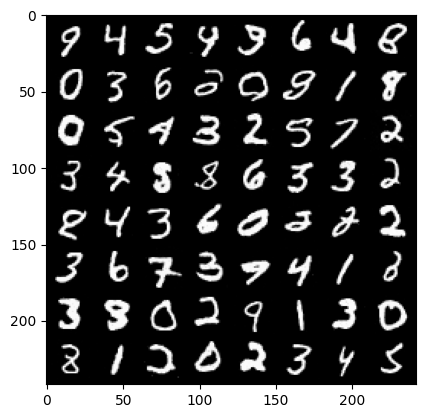

In [36]:
gen_sample = diffusion.sde_sample(dt=1e-2)
plt.imshow(ToPILImage()(make_grid(postprocess(gen_sample))))
plt.show()

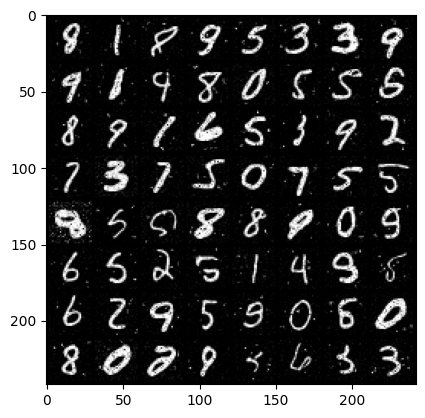

In [46]:
gen_sample = diffusion.sde_sample(dt=0.1)
plt.imshow(ToPILImage()(make_grid(postprocess(gen_sample))))
plt.show()

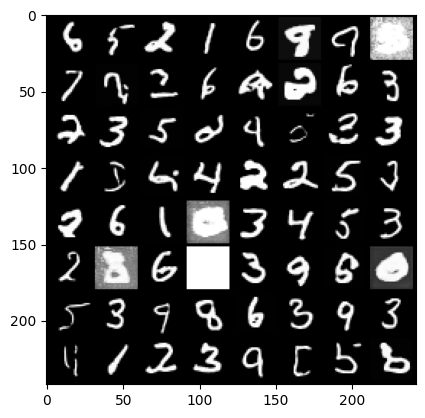

In [37]:
gen_sample = diffusion.ode_sample(dt=1e-2)
plt.imshow(ToPILImage()(make_grid(postprocess(gen_sample))))
plt.show()

In [38]:
ts = torch.tensor(torch.linspace(-1., -0., 60)).to(device)
ys = diffusion.sde_sample(t=ts, last_only=False)

<ipython-input-38-fadeeb609fb1>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ts = torch.tensor(torch.linspace(-1., -0., 60)).to(device)


In [39]:
def denoise_plot(ys, t, name: str = 'conn_ddpm'):
    Path('imgs').mkdir(exist_ok=True)
    if ys.is_cuda:
        ys = ys.cpu()
    for y, t in zip(ys, t):
        plt.imshow(ToPILImage()(make_grid(postprocess(y), normalize=True)))
        plt.title("%.2fs" % t)
        plt.axis('off')
        plt.margins(0, 0)
        plt.tight_layout()
        plt.savefig("imgs/ddpm-%.2f.png" % t)
        plt.close()

    images = []
    filenames = sorted(list(Path('imgs/').glob('*.png')))
    for filename in filenames:
        images.append(imageio.imread(str(filename)))
    imageio.mimsave(f'{name}.gif', images, duration=5, format='GIF')
    shutil.rmtree('imgs')

In [40]:
denoise_plot(ys.view((60, 64, 1, 28, 28)), torch.flip(-ts, (0, )))

![alt](https://github.com/sswt/dive2gai/blob/main/.github/images/w12/conn_ddpm.gif?raw=true)

Задания:

1. Попробовать другие методы решения ОДУ и СДУ (поменять солвер)
2. Поиграться с числом шагов семплирования
3. Попробовать поменять в SGM ядро перехода (VP или VE).